# Patholigist Assistant

## Introduction

In this assignment, the target is to expplore the approach and possibility to generate a model of patholigist assistant. The expectation is that the assistant can automatically answer certain questions based on the scanned image from X-ray, CT, MRI and other kind of source.
The problem is coming from a challenge from the website https://grand-challenge.org/, the link of the challenge is https://pathvqachallenge.grand-challenge.org/PathVQA_challenge/. All the data is provided by the owner of the challenge from https://github.com/UCSD-AI4H/PathVQA/tree/master/data.
@article{he2020pathvqa,
  title={PathVQA: 30000+ Questions for Medical Visual Question Answering},
  author={He, Xuehai and Zhang, Yichen and Mou, Luntian and Xing, Eric and Xie, Pengtao},
  journal={arXiv preprint arXiv:2003.10286},
  year={2020}
}

The original data includes two parts as illustrated below: 1. a json file to include the file name/index of the images, questions and related answers. 2. a zip file of all images. 
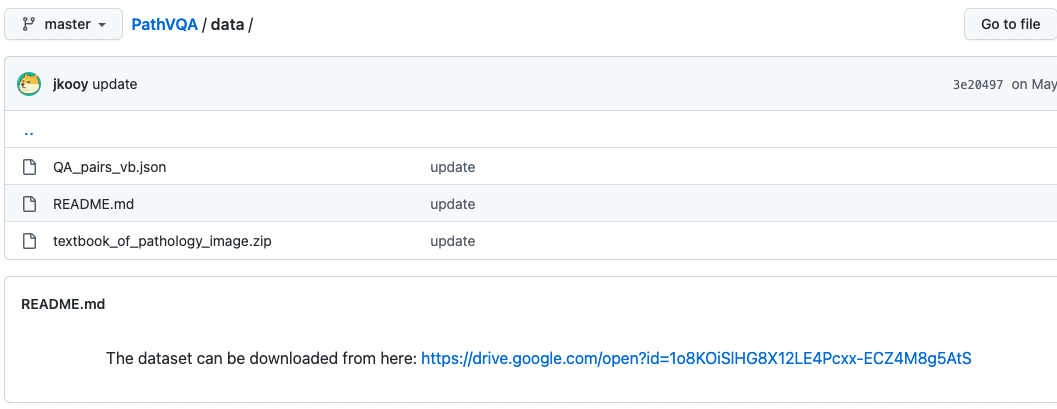

To have a further look at the original data, downloaded both of the files to local storage to avoid ssl configuration issue, the table looks like below. 

In [3]:
import matplotlib.pylab as plt
from PIL import Image
import os
import natsort
import pandas as pd
import numpy as np
%matplotlib inline

In [4]:
input = pd.read_json("QA_pairs_vb.json")
print(input)
input.describe()

     Image_ID                                          Questions  \
0       Fig.1  What are positively charged,  thus allowing th...   
1       Fig.1              How are the histone subunits charged?   
2       Fig.1  Are the histone subunits positively charged,  ...   
3       Fig.3  Where are liver stem cells (oval cells) located ?   
4       Fig.3  What are stained here with an immunohistochemi...   
...       ...                                                ...   
5424  img_885                    Is broad base also identified ?   
5425  img_885                            What have wavy nuclei ?   
5426  img_885                           What do the cells have ?   
5427  img_885                    Do the cells have wavy nuclei ?   
5428  img_885  Do individual myocardial fibres have wavy nucl...   

                                   Answers  
0                     the histone subunits  
1                       positively charged  
2                                      yes  
3  

,Image_ID,Questions,Answers
count,5429,5429,5429
unique,955,5013,2159
top,Fig.19,What is there ?,yes
freq,25,17,1463


## Data Preprocessing

The table includes raw data of image file, questions and answers. To continue, the data needs to be cleaned up and preprocessed.
To generate automatical answer based on image and question, we need to extract the feature from the image and the keyword from the questions and answers. To similify the problem area, in this assignmnet, the plan is to start with "yes/no" answers.
The data cleaning and  preprocessing includes:
1. Formalize the image file for sequece based index


In [5]:
#Normalize image file
df = input.copy()
image_path = "textbook_of_pathology_image"
image_list = natsort.natsorted(os.listdir(image_path))
image_col = df['Image_ID']
drop_list = []
for i in range(len(image_col)):
    if image_col[i].startswith("Fig."):
        seq = int(image_col[i].split(".")[1]),
        image_col[i] = image_list[seq[0]-1]
    elif not image_col[i].endswith(".jpg"):
        image_col[i] += ".jpg"
    
    if not image_col[i] in image_list:
        drop_list.insert(0, i)

for i in drop_list:
   df.drop(index=i, inplace=True)

2. Remove the samples with answers being other than "yes/no", and map yes to 1, no to 0. 

In [6]:
#Normalize answers to [1,0]
for i in df.index:
    if df.loc[i, 'Answers'].lower() == "yes":
        df.loc[i, 'Answers'] = "yes"
    elif df.loc[i, 'Answers'].lower() == "no":
        df.loc[i, 'Answers'] = "no"
    else:
        continue

df = df[df['Answers'].isin(['yes','no'])]
df.replace(['yes','no'], [1,0], inplace=True)

3. Extract the keyword from questions, set all the keywords as features of the table with value being the distance, then remove the original questions.

In [7]:
from keybert import KeyBERT
km = KeyBERT()

questions = df['Questions']
#print(len(questions))

ncs = {}
for r in range(len(questions)):
#for r in range(2):
    q = questions.iloc[r]
    #print(q)
    kw = km.extract_keywords(q)
    #print(kw)
    if (len(kw)>0):
        for (w, d) in kw:
            #print(w)
            if not w in ncs.keys():
                cw = [0] * len(df)
                #cw = pd.Series(l, copy=True)
                ncs[w] = cw
                #df[w]=cw
            #print(r,w,d)
            ncs[w][r] = d
            #df.loc[r,w] = d
new_features = pd.DataFrame(ncs)

indices = pd.Index([*range(len(df))])
df.insert(0, 'Index',indices)
df.set_index('Index', inplace=True)
new_features.insert(0, 'Index',indices)
new_features.set_index('Index', inplace=True)
df = pd.merge(df, new_features,how='inner', on='Index')
df.drop(columns=['Questions'],inplace=True)

4. Extract features from images. Considering there're many different kind of features to identify/categorize the image, the plan was to select two kinds of features for initial attempt: entropy and edge detection. But after including the two types of features, the complexity is too high to run the model on laptop computer, the calculation cannot be completed even for more than 1 day. So, the ultimate model can only be based on the features without edge detection.

In [8]:
from skimage import data, io, filters

img_features = {
    'Entropy': [0]*len(df),
    'Prewitt': [None]*len(df)
}

min_x = np.Infinity
min_y = np.Infinity
scope = range(len(df))
#scope = range(1);
for i in scope:
    img_file = image_path+"/"+df['Image_ID'].iloc[i]
    img = Image.open(img_file)
    img_features['Entropy'][i] = img.entropy()
    min_x = min(min_x, img.size[0])
    min_y = min(min_y, img.size[1])

tmp_file = image_path+"/"+'tmp.jpg'
for i in scope:
    img_file = image_path+"/"+df['Image_ID'].iloc[i]
    img = Image.open(img_file)
    scaled_img = img.resize((min_x,min_y),resample= Image.Resampling.LANCZOS)
    scaled_img.save(tmp_file)
    skimg = io.imread(tmp_file)
    #io.imshow(skimg)
    edge = filters.prewitt(skimg)
    img_features['Prewitt'][i] = edge
    #print(edge)
    os.remove(tmp_file)
    
new_features = pd.DataFrame(img_features)
new_features.insert(0, 'Index',indices)
new_features.set_index('Index', inplace=True)
df = pd.merge(new_features,df, how='inner', on='Index')

In [10]:
df.drop(columns=['Image_ID'], inplace=True)

After preprocessing, now the data is finalized as below.

In [11]:
df

,Entropy,Prewitt,Answers,histone,dna,compaction,subunits,positively,cytokeratin,bile,...,astrocytosis,neovascularisation,indicate,epidural,haematoma,firm,fibroblastic,image,pidural,neurofibroma
Index,,,,,,,,,,,,,,,,,,,,,
0,4.917722,"[[[0.01742374642538754, 0.015920545452239736, ...",1,0.4814,0.3896,0.3563,0.3391,0.2124,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.973165,"[[[0.009056474810817724, 0.009056474810817724,...",1,0.0000,0.0000,0.0000,0.0000,0.0000,0.4372,0.4307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.652260,"[[[0.024020534121721497, 0.018829042469783296,...",1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.652260,"[[[0.024020534121721497, 0.018829042469783296,...",0,0.5401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.652260,"[[[0.024020534121721497, 0.018829042469783296,...",1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,6.883623,"[[[0.009056474810817724, 0.009056474810817724,...",0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2846,6.883623,"[[[0.009056474810817724, 0.009056474810817724,...",0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2847,6.883623,"[[[0.009056474810817724, 0.009056474810817724,...",0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data model and training

As the target, the 'Answers' is a binary class with value 1 and 0, the criteria are contious value, considering the compelexisty of the data and the number of the data is not big enough, the ensemble model RandomForest is chosen to fit the task. To find the best parameters, the GridSearchCV function is adopted further.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import  RandomForestClassifier

drop_list = ['Image_ID','Prewitt_x', 'Prewitt_y','Prewitt']
for c in drop_list:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

target = 'Answers'
y = df[[target]]
x = df.drop(columns=[target])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25)
params={
#    'base_estimator' : [est_poly, est_rbf],
    'criterion': [ 'gini','entropy', 'log_loss'],
    'n_estimators':[10,50,100,150,200 ],
    'max_depth':[*range(10,100,10)],
    'max_features':['sqrt','log2']
} 

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=params, cv=3).fit(x_train,np.ravel(y_train))
print(grid.best_params_)

{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}


## Verification


According to the output from GridSearchCV, using the best parameters to create the final model to verify the score with test suite.

In [26]:
clf = RandomForestClassifier(
        criterion='log_loss', 
        max_depth = 10, 
        max_features = 'sqrt', 
        n_estimators=10
    ).fit(x_train, np.ravel(y_train))
accuracy = clf.score(x_test, np.ravel(y_test))
print(accuracy)

0.517531556802244


## Conclusion

The ultimate testing score is only about 52%, it cannot meet the requirement from the real world. The reason of the low actuaccy could be because of the following factors:
1. Too less data
2. The imaging processing part contributes too less information, which means it needs much more calculation on image part, but there is not enough computing resource for the assignment.

To complete the challenge, more work on collecting data and more importantly, the imaging processing part needs to be improved.